## Библиотеки 

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller, coint
from statsmodels.tsa.api import VAR, VECM, ARDL
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank

import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
import warnings

warnings.filterwarnings("ignore")

На локальном компьютере при попытке импортировать пакет Йохансен может возникнуть проблема, для её решения необходимо руками открыть пакет johansen.py (можно даже в блокноте) и изменить строку import critical_values на from johansen import critical_values

In [ ]:
from johansen import Johansen

In [7]:
# тест Дики-Фуллера
# немного отличается от стандартного вывода adfuller()
def adf_test(timeseries, regression, maxlag = None):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC',
                      store=False, regresults=False)
    results = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC',
                       store=True, regresults=True)[3].resols

    results.model.exog_names[0] = 'y(-1)'

    for item in range(dftest[2]):
        results.model.exog_names[item+1] = 'dy(' + str(-item-1) + ')'

    trend_len = regression.count('t')
    if trend_len > 0:
        for item in range(trend_len):
            results.model.exog_names[dftest[2]+item+2] = 'trend' + str(item+1)

    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    return results

In [8]:
# тест Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
def kpss_test(timeseries, regression, nlags = 'auto'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags = nlags)

    kpssoutput = pd.Series(
        kpsstest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value
    print(kpssoutput)

In [9]:
# Johansen test
def joh_test(data, n_lags_diff):

  for i in range(0, 5, 1):
    joh = Johansen(data, model = i, significance_level = 1, k = n_lags_diff)
    eigenvectors, rejected_r = joh.johansen()
    try:
      rank = rejected_r[-1] + 1
    except:
      rank = 'no cointegration'
    print("Модель", i + 1, " ранг коинтеграции: ", rank)

In [10]:
# VECM selection

def vecm_selection(data, n_lags_diff):

  models = dict({0 : 'none', 1 : 'ci', 2 : 'co', 3 : 'cili', 4 : 'colo'})

  for i in range(0, 5, 1):
      joh = Johansen(data, model = i, significance_level = 1, k = n_lags_diff)
      eigenvectors, rejected_r = joh.johansen()
      try:
        rank = rejected_r[-1] + 1

        mod = VECM(data, coint_rank = rank, deterministic = models[i], k_ar_diff = n_lags_diff).fit()

        endog = len(mod.sigma_u)
        det = dict({0 : 0, 1 : rank, 2 : endog, 3 : 2 * rank, 4 : 2 * endog})
        # AIC, BIC
        K = endog ** 2 + 2 * endog * rank + det[i]
        aic = 2 * ( K / mod.nobs) - 2 * mod.llf / mod.nobs
        bic = np.log(mod.nobs) * ( K / mod.nobs) - 2 * mod.llf / mod.nobs

        print("Модель VECM", i+1, "  ранг коинтеграции:", rank, "AIC =", np.round(aic, 3), "BIC =", np.round(bic, 2), "Log L =", np.round(mod.llf, 2))

      except:
        rank = 0

        det = dict({0 : 'n', 1 : 'n', 2 : 'c', 3 : 'n', 4 : 'ct'})

        mod = VAR(data.diff(1).dropna()).fit(trend = det[i])

        print("Модель VAR в разностях", det[i], "  ранг коинтеграции:", rank, "AIC =", np.round(mod.aic, 3), "BIC =", np.round(mod.bic, 2), "Log L =", np.round(mod.llf, 2))


## Задание 1 
       
В файле z_6_4.csv приведены реализации пяти временных рядов: X1, X2, X3, Y и Z.



In [11]:
data = pd.read_csv('z_6_4.csv')
data.head()

,X1,X2,X3,Y,Z
0,0.000000,0.000000,0.000000,-19.990314,18.293818
1,0.000000,0.000000,0.000000,-19.653184,20.762481
2,1.056155,0.202922,-0.106084,-19.491494,20.563341
3,2.635852,-0.511732,-1.256629,-15.979108,17.456773
4,1.001033,-1.645068,0.796344,-18.689634,20.084252


### 1) Убедиться в том, что это I(1) ряды. 

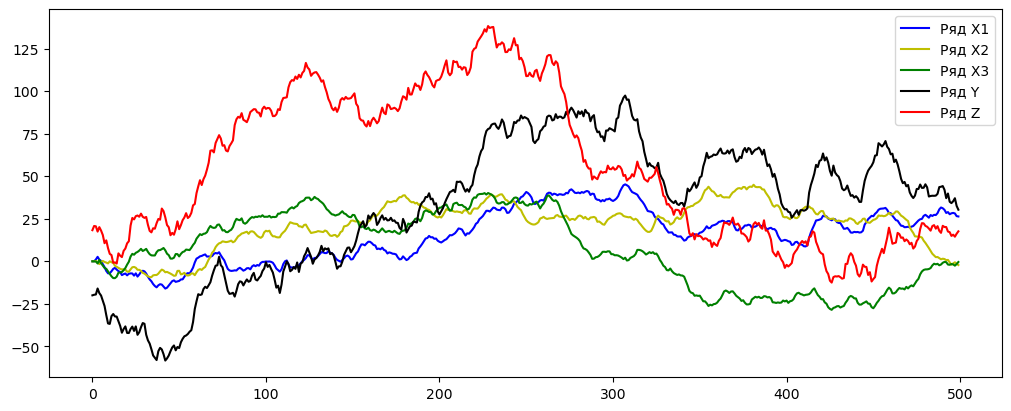

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.plot(data['X1'],'b-', label = 'Ряд X1')
ax.plot(data['X2'],'y-', label = 'Ряд X2')
ax.plot(data['X3'],'g-', label = 'Ряд X3')
ax.plot(data['Y'],'k-', label = 'Ряд Y')
ax.plot(data['Z'],'r-', label = 'Ряд Z')

ax.legend()

plt.show()

Проведем тест adf для всех пяти рядов, при этом визуально на графике видим, что ряды X1 X2 X3 не имеют константы => их оцениваем без константы и тренда, ряды y и z преположительно имеют константу.

Если гипотеза единичного корня отвергается, то по aic выбираем лучшую модель и смотрим, что там с гипотезой ед. корня

*Ряд X1*

In [14]:
#H0: I(1)
adf_test(data['X1'], 'n')

Results of Dickey-Fuller Test:
Test Statistic                  -0.641931
p-value                          0.437047
#Lags Used                       1.000000
Number of Observations Used    498.000000
Critical Value (1%)             -2.570244
Critical Value (5%)             -1.941553
Critical Value (10%)            -1.616297
dtype: float64


*Ряд X2*

In [15]:
adf_test(data['X2'], 'n')

Results of Dickey-Fuller Test:
Test Statistic                  -0.863335
p-value                          0.344043
#Lags Used                       3.000000
Number of Observations Used    496.000000
Critical Value (1%)             -2.570262
Critical Value (5%)             -1.941555
Critical Value (10%)            -1.616295
dtype: float64


*Ряд X3*

In [16]:
adf_test(data['X3'], 'n')

Results of Dickey-Fuller Test:
Test Statistic                  -0.972237
p-value                          0.299291
#Lags Used                       1.000000
Number of Observations Used    498.000000
Critical Value (1%)             -2.570244
Critical Value (5%)             -1.941553
Critical Value (10%)            -1.616297
dtype: float64


Для радов X1-X3 гипотеза единичного корня не отвергается (p_value>0.05 у всех) => ряды I(1)

*Ряд Y*

In [17]:
adf_test(data['Y'], 'c')

Results of Dickey-Fuller Test:
Test Statistic                  -1.614158
p-value                          0.475793
#Lags Used                       5.000000
Number of Observations Used    494.000000
Critical Value (1%)             -3.443657
Critical Value (5%)             -2.867408
Critical Value (10%)            -2.569896
dtype: float64


*Ряд Z*

In [18]:
adf_test(data['Z'], 'c')

Results of Dickey-Fuller Test:
Test Statistic                  -1.045323
p-value                          0.736377
#Lags Used                       2.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64


Для рядов Y и Z с const гипотеза единичного корня также не овтергается (p_value>0.05 у обоих ) следовательно ряды I(1)

Вывод: Все ряды являются нестационарными I(1)

### 2) Построить модели порождения рядов X1, X2, X3

X1

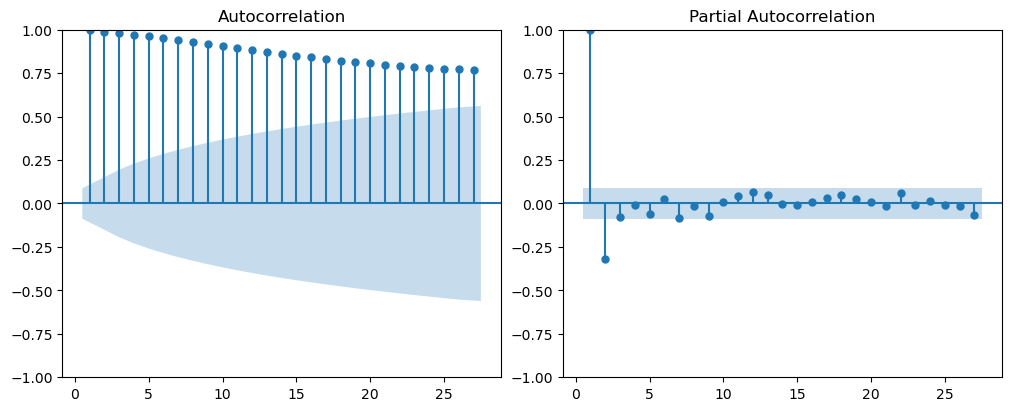

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(data['X1'], zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(data['X1'], method = 'ywm', zero = False, ax = ax2)
plt.show()
#затухание PACF на первом лаге => AR(1)

In [21]:
mod = sm.tsa.statespace.SARIMAX(data['X1'], trend='n', order=(1,1,0))
res = mod.fit(disp = False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                     X1   No. Observations:                  500
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -703.927
Date:                Thu, 26 Jun 2025   AIC                           1411.854
Time:                        20:50:52   BIC                           1420.280
Sample:                             0   HQIC                          1415.161
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4904      0.042     11.706      0.000       0.408       0.573
sigma2         0.9831      0.061     16.099      0.000       0.863       1.103
Ljung-Box (L1) (Q):                   0.05   Jarque-

p-value = 0.591


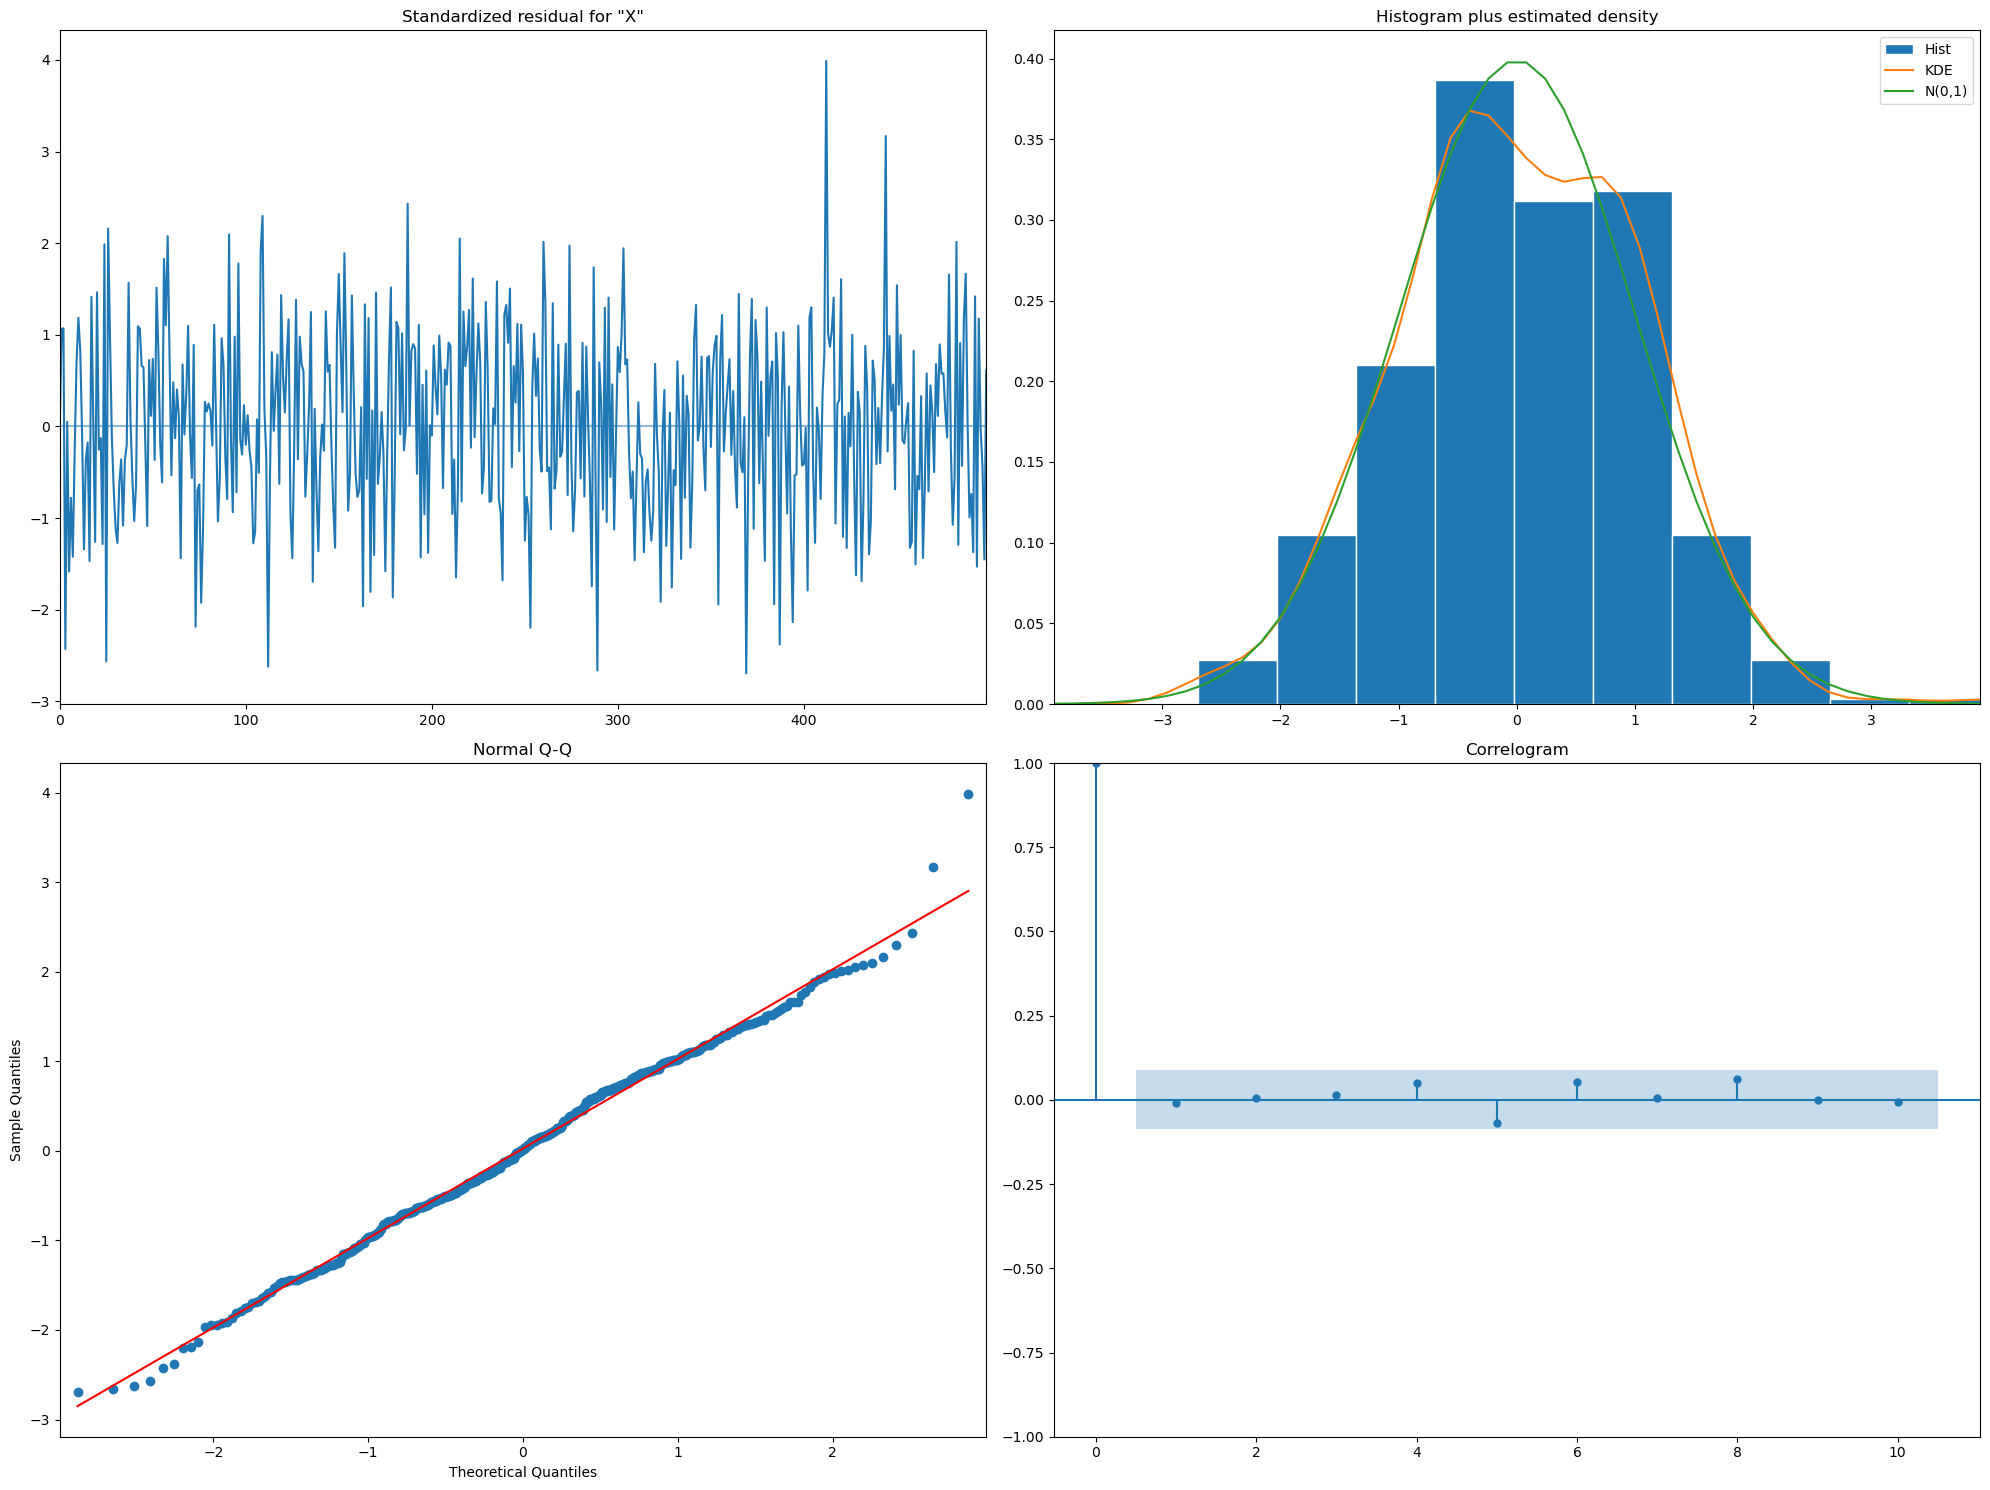

In [22]:
#диагностика остатков
#H0: отсутсвие корреляции в остатках
print('p-value =', np.round(bgtest(res, nlags = 5)[1], 3))
res.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

X2

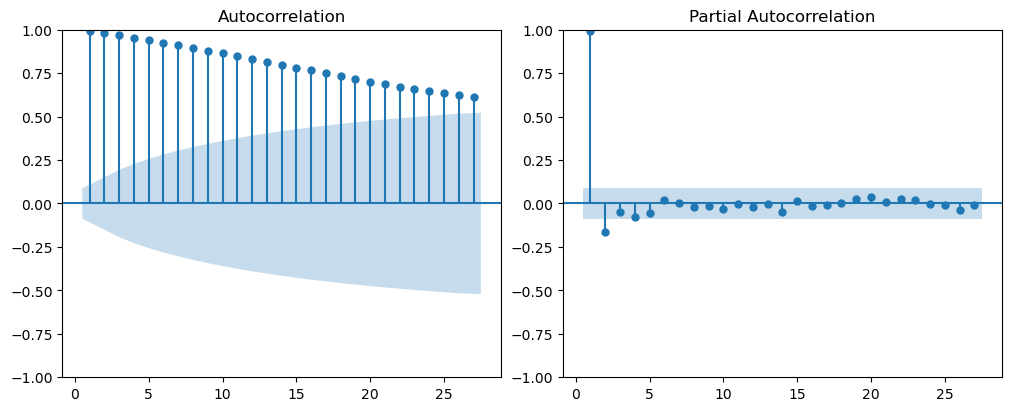

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(data['X2'], zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(data['X2'], method = 'ywm', zero = False, ax = ax2)
plt.show()
#затухание PACF на первом лаге => AR(1)

In [23]:
mod = sm.tsa.statespace.SARIMAX(data['X2'], trend='n', order=(1,1,0))
res = mod.fit(disp = False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                     X2   No. Observations:                  500
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -660.279
Date:                Thu, 26 Jun 2025   AIC                           1324.558
Time:                        20:51:06   BIC                           1332.983
Sample:                             0   HQIC                          1327.864
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4950      0.041     12.166      0.000       0.415       0.575
sigma2         0.8253      0.052     15.928      0.000       0.724       0.927
Ljung-Box (L1) (Q):                   0.03   Jarque-

p-value = 0.253


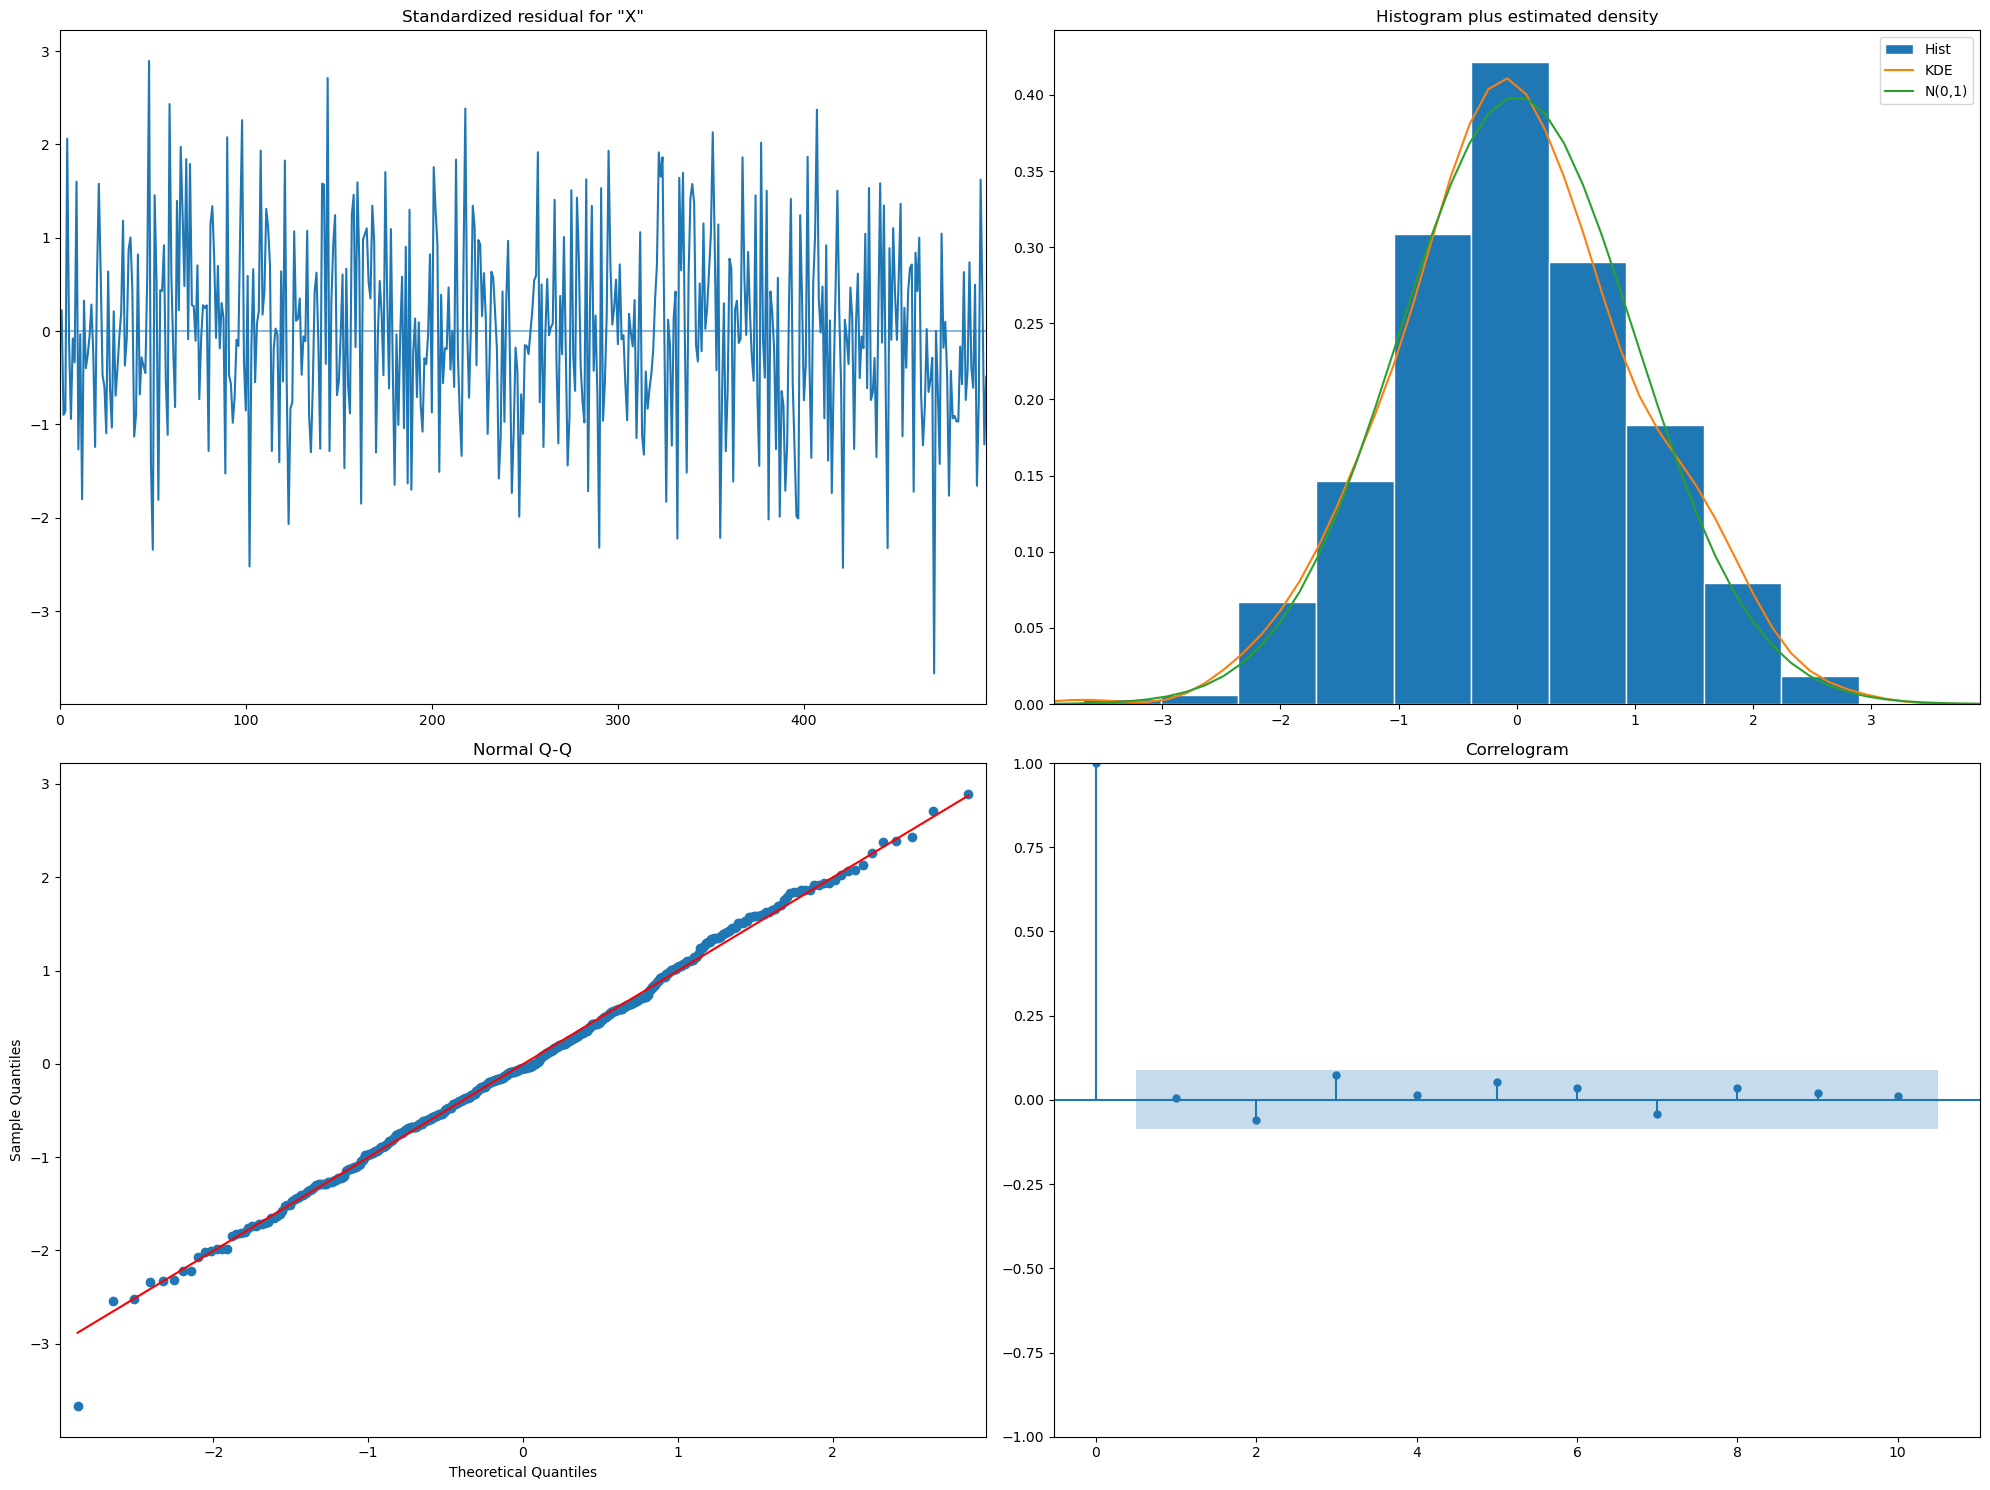

In [24]:
#диагностика остатков
#H0: отсутсвие корреляции в остатках
print('p-value =', np.round(bgtest(res, nlags = 5)[1], 3))
res.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

X3

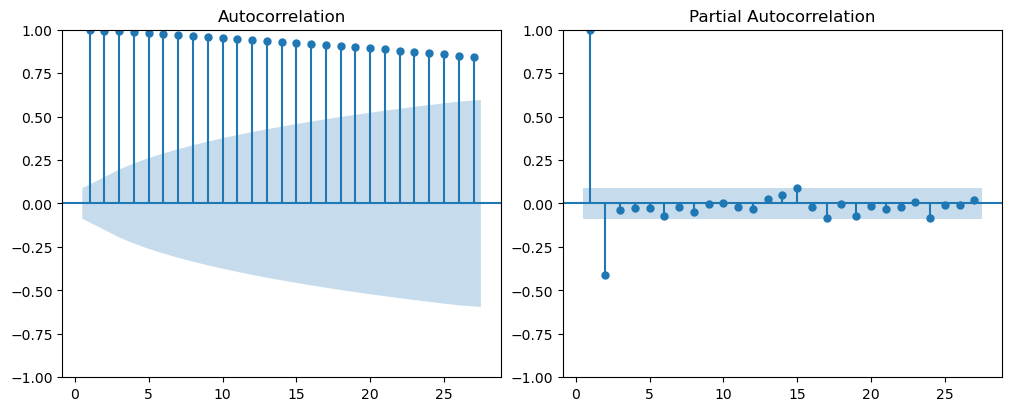

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(data['X3'], zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(data['X3'], method = 'ywm', zero = False, ax = ax2)
plt.show()
#затухание PACF на первом лаге => AR(1)

In [25]:
mod = sm.tsa.statespace.SARIMAX(data['X3'], trend='n', order=(1,1,0))
res = mod.fit(disp = False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                     X3   No. Observations:                  500
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -732.727
Date:                Thu, 26 Jun 2025   AIC                           1469.454
Time:                        20:51:15   BIC                           1477.879
Sample:                             0   HQIC                          1472.761
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4591      0.040     11.476      0.000       0.381       0.537
sigma2         1.1034      0.072     15.381      0.000       0.963       1.244
Ljung-Box (L1) (Q):                   0.01   Jarque-

p-value = 0.921


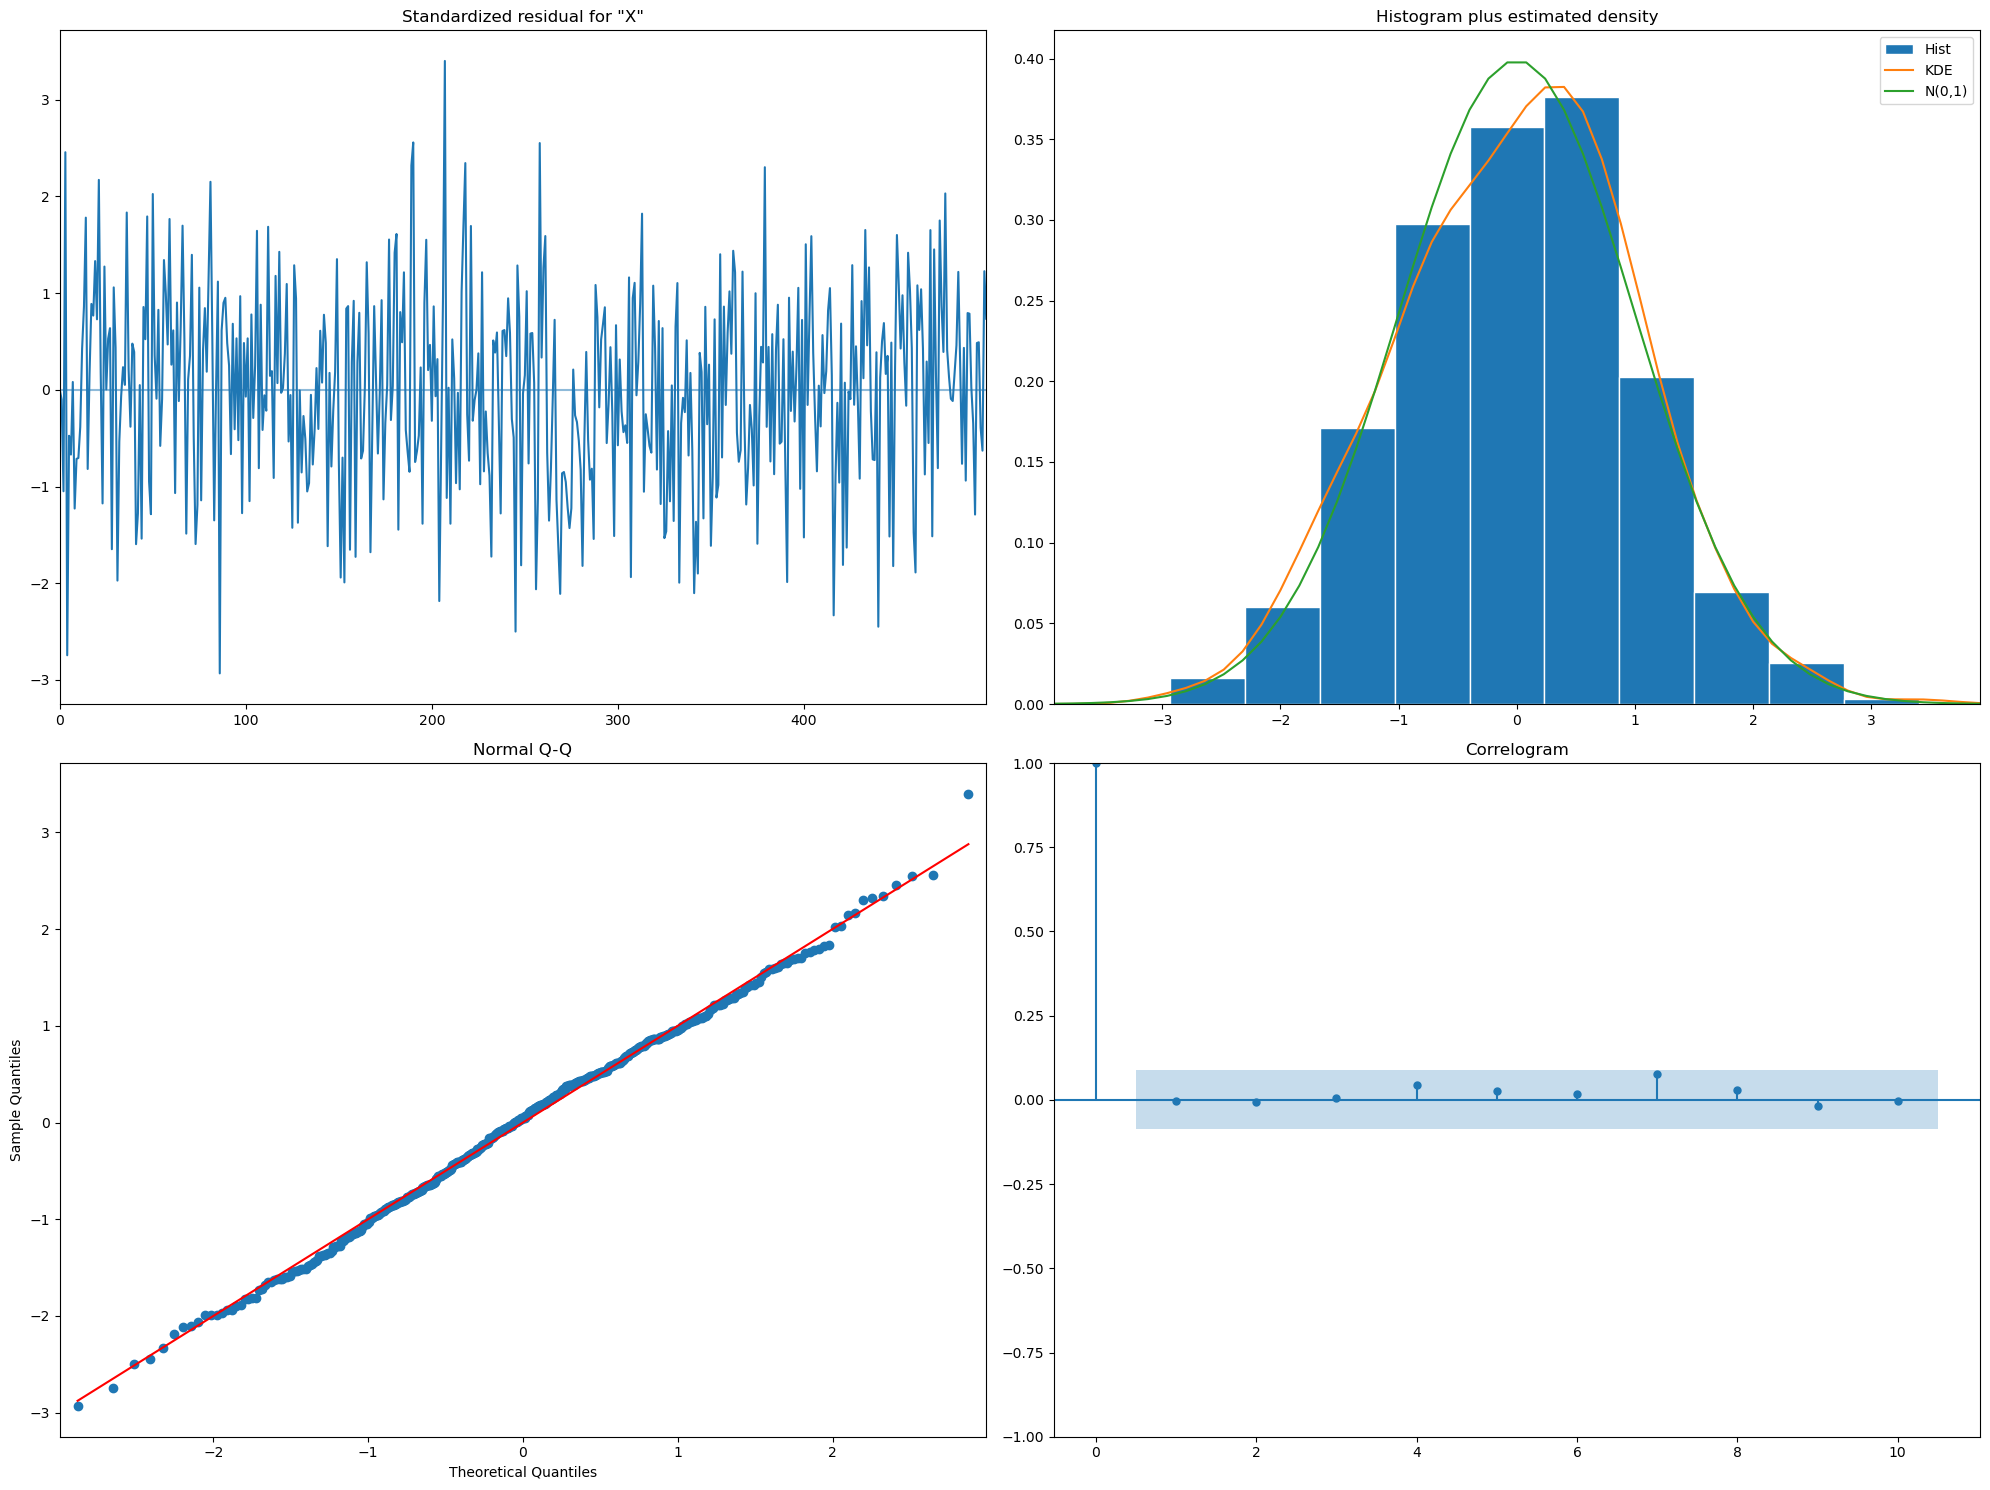

In [26]:
#диагностика остатков
#H0: отсутсвие корреляции в остатках
print('p-value =', np.round(bgtest(res, nlags = 5)[1], 3))
res.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

Выводы по всем трем моделям X1 X2 X3:
При анализе ACF и PACF видим, что PACF резко обрывается после первого лага (у всех трех рядов) при этом ACF медленно затухает (слишком медленно => единичный корень) из чего можем преположить модель AR(1)

Так как до этого мы выяснили, что эти ряды I(1) => для каждой модели берем ARMA(1,1,0)

После оценки всех трех моделей, убедились, что все коэффициенты при обьясняющих переменных значимы

Проведем диагностику остатков для всех трех моделей:

1. Для всех трех моделей на визуальной диагностике остатков видно, что остатки имеют нормально распредление и ACF не выходит за пределы доверительного интервала => остатки белошумные и нет автокорреляции 

2. Для всех трех моделей провели тест Бройша-Годфри, для каждой из трех оцененых моедлей нулевая гипотеза об отсутсвии кореляции в остатках не отвергается

Из всего выше сказанного можем сделать вывод, что модели определены верно.
В разностях:

$ΔX1_t=0.4904ΔX1_{t-1}+e1_t$  
$ΔX2_t=0.4950ΔX2_{t-1}+e2_t$  
$ΔX3_t=0.4591ΔX3_{t-1}+e3_t$ 

В уровнях:

$X1_t=1.4904X1_{t-1}-0.4904X1_{t-2}+e1_t$  
$X2_t=1.4950X2_{t-1}-0.4950X2_{t-2}+e2_t$  
$X3_t=1.4591X3_{t-1}-0.4591X3_{t-2}+e3_t$ 

$$

### 3) Используя метод Йохансена, оценить ранг коинтеграции системы 5 рядов, выбрав ситуацию, соответствующую наблюдаемой динамике этих рядов.  Упорядочить ряды в порядке Y, Z, X1, X2, X3. В качестве критерия использовать **BIC** 


In [27]:
# выберем порядок модели VAR(P)->VECM(P-1)
mod = VAR(data[['Y', 'Z', 'X1', 'X2', 'X3']])
mod.select_order(maxlags = 4).summary()

,AIC,BIC,FPE,HQIC
0,16.49,16.53,1.446e+07,16.50
1,0.7224,0.9768,2.059,0.8223
2,0.03320*,0.4997*,1.034*,0.2163*
3,0.09375,0.7722,1.098,0.3601
4,0.1551,1.046,1.168,0.5046


VAR(2)->VECM(1) подобрали таким образом число запаздывающих разностей

Далее выберем лучшую из пяти моделей на основе bic => у нас будет лучшая модель, число запаздывающих разностей и ранг коинтеграции модели, что даст нам возможность оценить VECM модель

In [28]:
# переберём варианты, указывая число запаздываюющих разностей в VECM
joh_test(data[['Z', 'Y', 'X1', 'X2', 'X3']], n_lags_diff = 1)


Модель 1  ранг коинтеграции:  1
Модель 2  ранг коинтеграции:  2
Модель 3  ранг коинтеграции:  2
Модель 4  ранг коинтеграции:  2
Модель 5  ранг коинтеграции:  2


In [29]:
# выбрать лучшую по значению BIC VECM-модель - модель номер 2 :
vecm_selection(data[['Z', 'Y', 'X1', 'X2', 'X3']], n_lags_diff = 1)

Модель VECM 1   ранг коинтеграции: 1 AIC = 14.588 BIC = 14.88 Log L = -3597.36
Модель VECM 2   ранг коинтеграции: 2 AIC = 14.223 BIC = 14.62 Log L = -3494.53
Модель VECM 3   ранг коинтеграции: 2 AIC = 14.234 BIC = 14.66 Log L = -3494.34
Модель VECM 4   ранг коинтеграции: 2 AIC = 14.217 BIC = 14.63 Log L = -3491.05
Модель VECM 5   ранг коинтеграции: 2 AIC = 14.232 BIC = 14.7 Log L = -3488.65


Лучшая модель 2 (ci) (BIC = 14.62) , ранг коинтеграции для нее 2

### 4) Оцените модель коррекции ошибок для этой системы 5 рядов (с оцененным рангом и с выбранной ситуацией). 

In [30]:
mod_vecm = VECM(data[['Z', 'Y', 'X1', 'X2', 'X3']], coint_rank = 2, k_ar_diff = 1, deterministic = 'ci')
res_vecm = mod_vecm.fit()
print(res_vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Z
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Z          -0.0811      0.114     -0.708      0.479      -0.305       0.143
L1.Y          -0.1040      0.114     -0.912      0.362      -0.328       0.120
L1.X1          0.1792      0.252      0.712      0.477      -0.314       0.673
L1.X2          0.7113      0.197      3.616      0.000       0.326       1.097
L1.X3          1.0957      0.242      4.535      0.000       0.622       1.569
Det. terms outside the coint. relation & lagged endog. parameters for equation Y
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Z           0.0652      0.107      0.609      0.543      -0.145       0.275
L1.Y          -0.0233      0.107     -0.218     

Оцененная модель VECM

$β^T=\begin{pmatrix} 1 & 0 & 0 & -1 & -2  \\  0 & 1 & -2 & -1 & 0 \end{pmatrix}$
$α=\begin{pmatrix} -0.88 & 0  \\ 0 & -1.05 \\ 0 & 0\\ 0 & 0\\ 0 & 0\end{pmatrix}$
$μ=\begin{pmatrix} -20  \\  20\\0\\0\\0\end{pmatrix}$
$П=α*β^T=\begin{pmatrix} -0.88 & 0 & 0 & 0.88 & 1.76 \\ 0 & -1.05 & 2.1 & 1.05 & 0 \\ 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 0\end{pmatrix}$

$\begin{pmatrix} ΔZ_t \\ ΔY_t \\ ΔX1_t \\ ΔX2_t \\ ΔX3_t \end{pmatrix} = μ + П*\begin{pmatrix} Z_{t-1} \\ Y_{t-1} \\ X1_{t-1} \\ X2_{t-1} \\ X3_{t-1} \end{pmatrix} + \begin{pmatrix} 0 & 0 & 0 & 0.71 & 1.09 \\ 0 & 0 & 1 & 0.48 & 0 \\ 0 & 0 & 0.5 & 0 & 0\\ 0 & 0 & 0 & 0.53 & 0\\ 0 & 0 & 0 & 0 & 0.52\end{pmatrix} * \begin{pmatrix} ΔZ_{t-1} \\ ΔY_{t-1} \\ ΔX1_{t-1} \\ ΔX2_{t-1} \\ ΔX3_{t-1} \end{pmatrix} + \begin{pmatrix} e1_t  \\  e2_t\\e3_t\\e4_t\\e5_t\end{pmatrix} $


## Задание 7 (15 очков)

Файл z_7.csv содержит данные о значениях двух переменных x и у.

    
Подобрать по этим данным динамическую модель, в которой объясняемой является переменная y, а в качестве экзогенной выступает переменная x.

In [91]:
data=pd.read_csv('z_7.csv')
data.head()

,obs,X,Y
0,1960,1.000000,4.000000
1,1961,0.608765,4.000000
2,1962,2.348649,6.367337
3,1963,1.273028,5.992381
4,1964,2.635370,5.569621


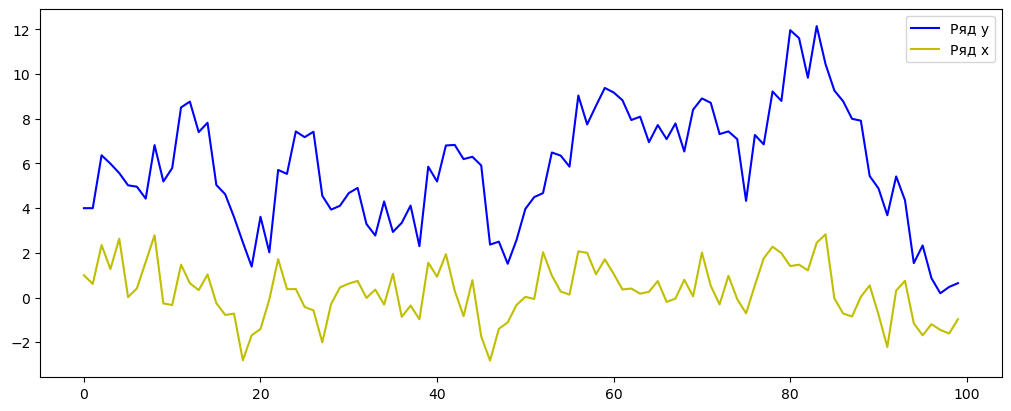

In [92]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.plot(data['Y'],'b-', label = 'Ряд y')
ax.plot(data['X'],'y-', label = 'Ряд x')


ax.legend()

plt.show()

Проверим оба ряда на стационарность с помощью теста Дики-Фуллера, в обоих случаях при графическом анализе видим константу.

In [93]:
adf_test(data['X'], 'c')

Results of Dickey-Fuller Test:
Test Statistic                 -5.375032
p-value                         0.000004
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [94]:
adf_test(data['Y'], 'c')

Results of Dickey-Fuller Test:
Test Statistic                 -2.872800
p-value                         0.048604
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


Для ряда X и Y гипотеза единичного корня отвергается, так как p-value в обоих случаях меньше 0.05 => оба ряда стационарны\
Возьмем в качестве SM модели полную модель ADL(1,1,1) \
Если коэффиценты будут незначимы, проведем редукцию модели, тк преполагаем, что моель порождения данных одна из частных случаев модели ADL(1,1,1)

                              ARDL Model Results                              
Dep. Variable:                      Y   No. Observations:                  100
Model:                     ARDL(1, 1)   Log Likelihood                -153.414
Method:               Conditional MLE   S.D. of innovations              1.140
Date:                Tue, 08 Jul 2025   AIC                            316.828
Time:                        22:28:42   BIC                            329.804
Sample:                             1   HQIC                           322.078
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3529      0.340      3.977      0.000       0.677       2.028
Y.L1           0.7351      0.058     12.783      0.000       0.621       0.849
X.L0           0.7613      0.114      6.705      0.0

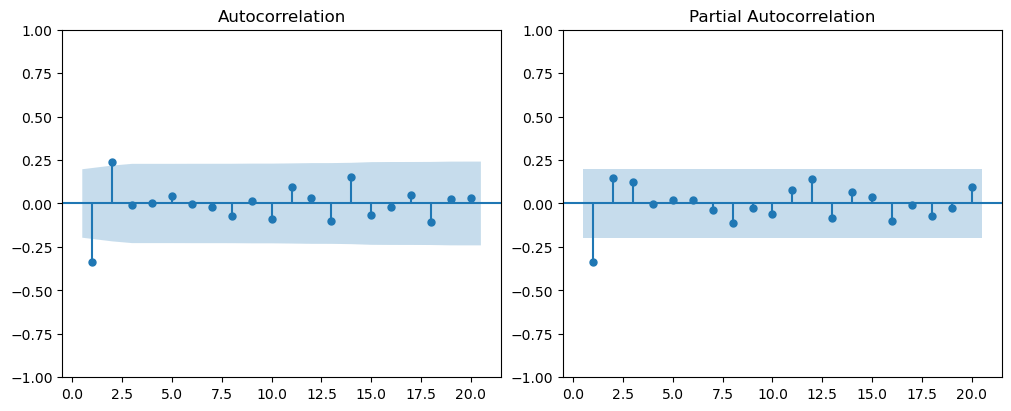

In [138]:
#полная модель
res_ardl = ARDL(data['Y'], 1, data[['X']],{'X':1}, trend='c').fit()
print(res_ardl.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res_ardl.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res_ardl.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:                        SARIMAX   Log Likelihood                -167.347
Date:                Tue, 08 Jul 2025   AIC                            338.695
Time:                        21:29:39   BIC                            343.885
Sample:                             0   HQIC                           340.794
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.5476      0.113      4.849      0.000       0.326       0.769
sigma2         1.7210      0.273      6.300      0.000       1.186       2.256
Ljung-Box (L1) (Q):                  10.82   Jarque-

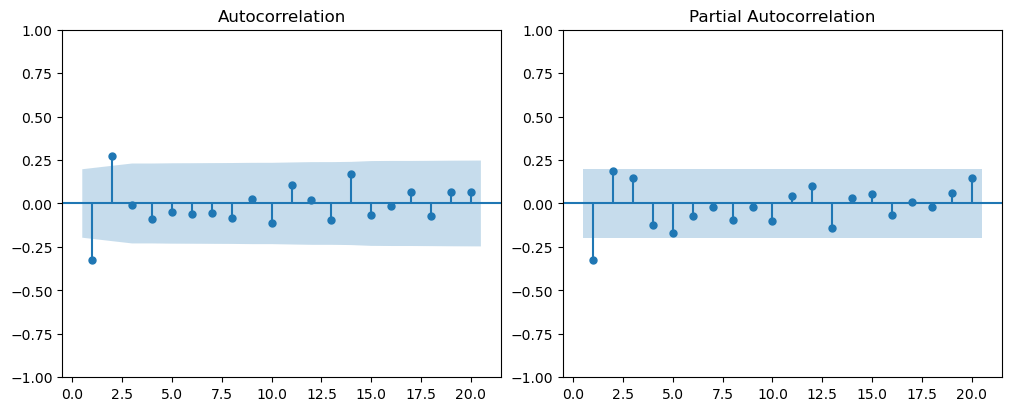

In [134]:
#модель скорости роста 
mod = sm.tsa.statespace.SARIMAX(np.diff(data['Y'],1), trend='n', order=(0,0,0), exog = data['X'].diff(1).dropna())
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                -215.471
Date:                Tue, 08 Jul 2025   AIC                            436.943
Time:                        21:24:51   BIC                            444.758
Sample:                             0   HQIC                           440.106
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.4993      0.221     24.867      0.000       5.066       5.933
x(-1)          1.2846      0.169      7.584      0.000       0.953       1.617
sigma2         4.3559      0.734      5.933      0.0

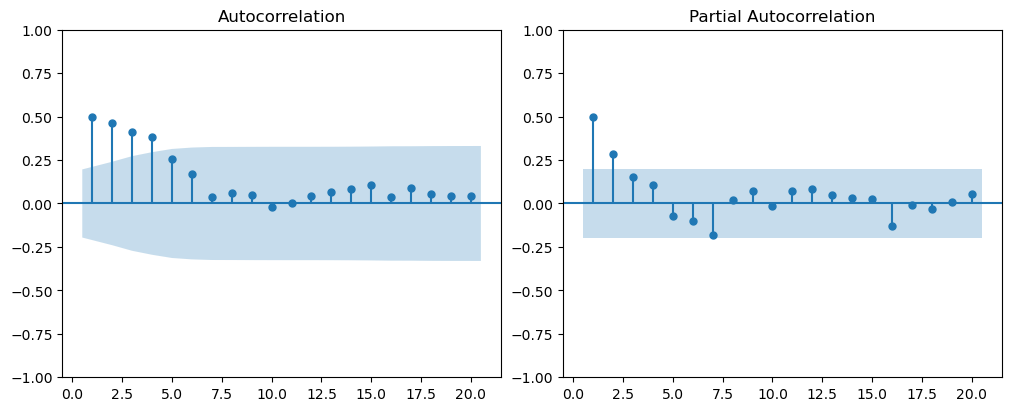

In [131]:
# модель опережающего показателя
mod = sm.tsa.statespace.SARIMAX(data['Y'], trend='c', order=(0,0,0), exog = data['x(-1)'])
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -176.642
Date:                Tue, 08 Jul 2025   AIC                            361.284
Time:                        21:30:25   BIC                            371.704
Sample:                             0   HQIC                           365.501
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8610      0.374      2.304      0.021       0.128       1.594
x(-1)          0.0866      0.147      0.588      0.556      -0.202       0.375
ar.L1          0.8432      0.061     13.755      0.0

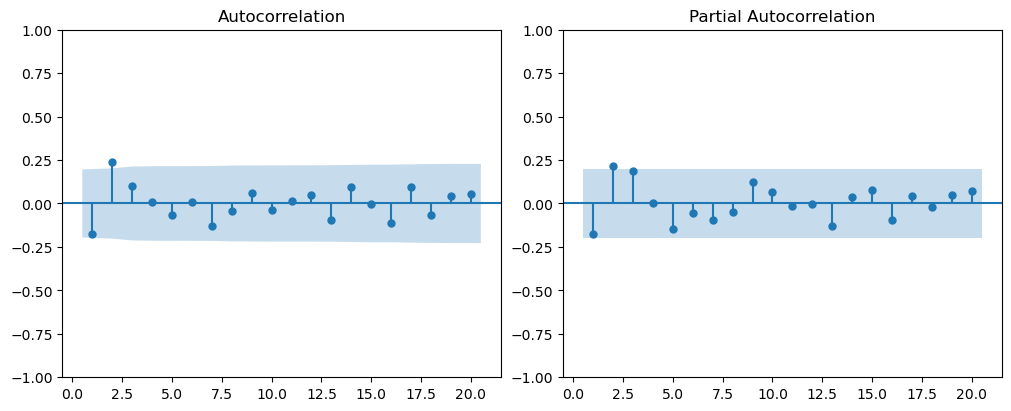

In [136]:
# приведенная форма
mod = sm.tsa.statespace.SARIMAX(data.Y, trend='c', order=(1,0,0), exog = data['x(-1)'])
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -165.769
Date:                Tue, 08 Jul 2025   AIC                            339.537
Time:                        21:30:37   BIC                            349.958
Sample:                             0   HQIC                           343.755
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8620      0.393      2.194      0.028       0.092       1.632
X              0.5761      0.118      4.893      0.000       0.345       0.807
ar.L1          0.8397      0.066     12.792      0.0

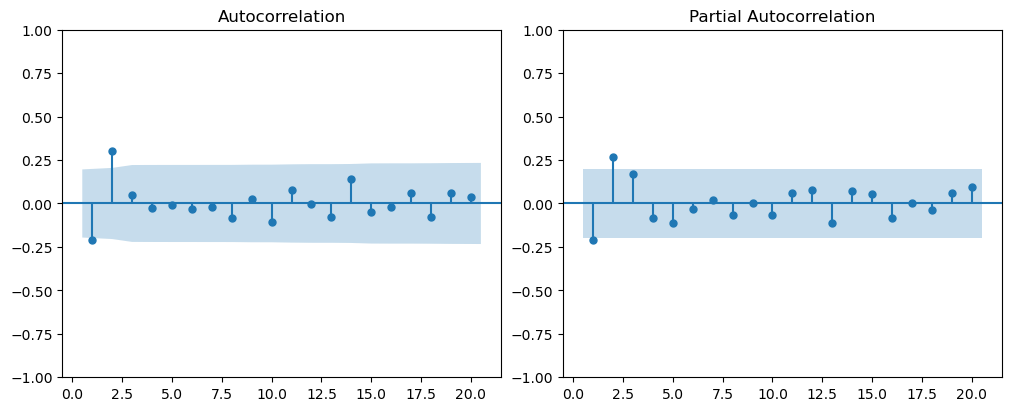

In [137]:
#модель частичной корректировки
mod = sm.tsa.statespace.SARIMAX(data['Y'], trend='c', order=(1,0,0), exog = data['X'])
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -176.858
Date:                Tue, 08 Jul 2025   AIC                            359.716
Time:                        22:31:05   BIC                            367.531
Sample:                             0   HQIC                           362.879
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8156      0.365      2.237      0.025       0.101       1.530
ar.L1          0.8513      0.060     14.262      0.000       0.734       0.968
sigma2         1.9865      0.273      7.274      0.0

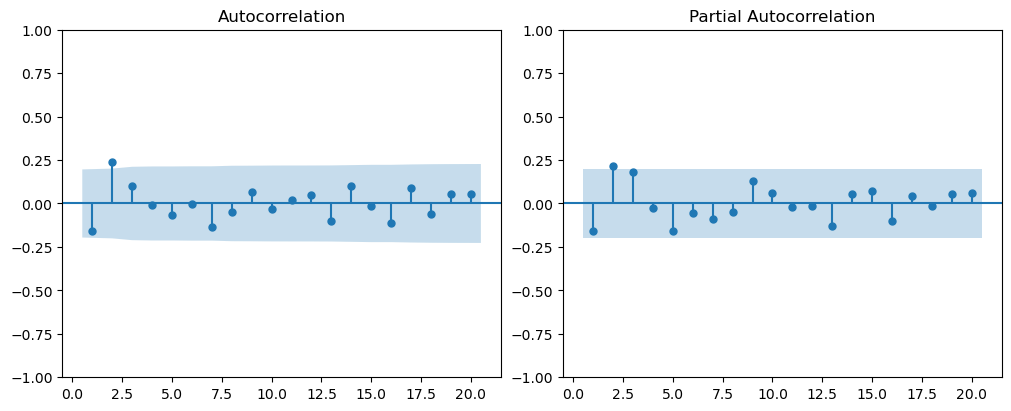

In [139]:
# авторегрессия
mod = sm.tsa.statespace.SARIMAX(data.Y, trend='c', order=(1,0,0))
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                -214.315
Date:                Tue, 08 Jul 2025   AIC                            434.630
Time:                        22:31:49   BIC                            442.446
Sample:                             0   HQIC                           437.793
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5067      0.215     25.597      0.000       5.085       5.928
X              1.3042      0.169      7.696      0.000       0.972       1.636
sigma2         4.2564      0.786      5.416      0.0

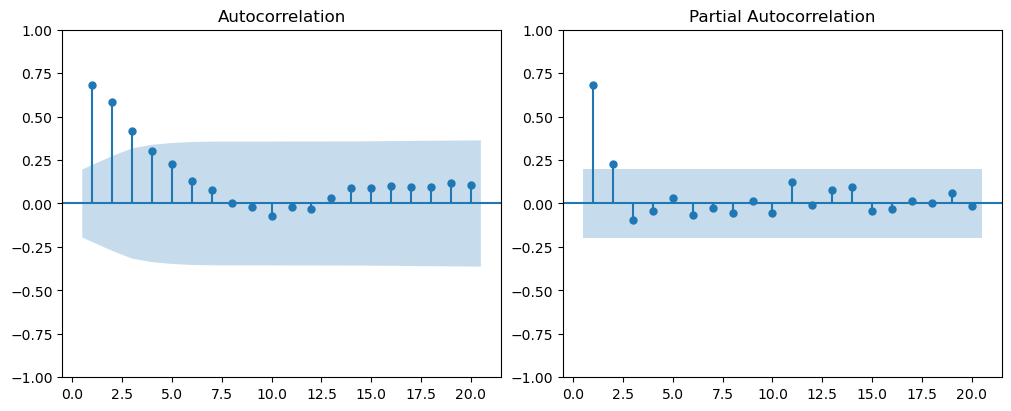

In [140]:
# статическая регрессия
mod = sm.tsa.statespace.SARIMAX(data.Y, trend='c', order=(0,0,0), exog = data['X'])
res = mod.fit(disp = False)
print(res.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

После редукции модели до одного из частных случаев (всего 6 - не проводим оценивание модели авторегриссонных ошибок и модели коррекции ошибок) модель приведенной формы и модель авторегрессии на основе визуального анализа графиков ACF/PACF остатков не имеют авторегрессии остатков => выберем одну из двух моделей

Авторегрессия

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -176.858
Date:                Tue, 08 Jul 2025   AIC                            359.716
Time:                        23:19:52   BIC                            367.531
Sample:                             0   HQIC                           362.879
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8156      0.365      2.237      0.025       0.101       1.530
ar.L1          0.8513      0.060     14.262      0.000       0.734       0.968
sigma2         1.9865      0.273      7.274      0.0

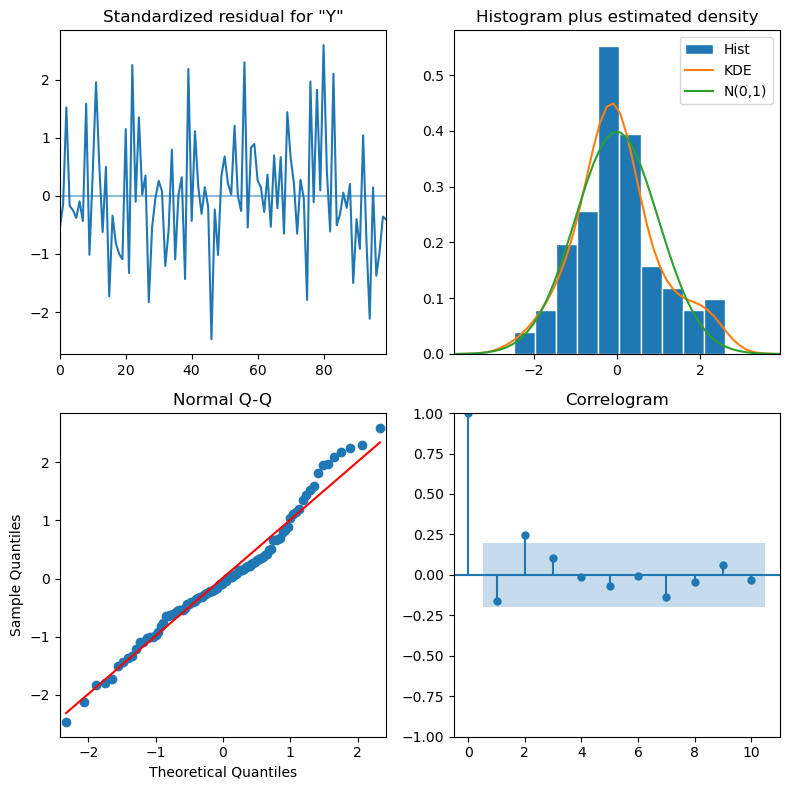

In [173]:
mod = sm.tsa.statespace.SARIMAX(data.Y, trend='c', order=(1,0,0))
res = mod.fit(disp = False)

print(res.summary())
print('p-value =', np.round(bgtest(res, nlags = 6)[1], 5))
res.plot_diagnostics(figsize=(8, 8))
plt.tight_layout()


Приведенная форма 

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -176.642
Date:                Tue, 08 Jul 2025   AIC                            361.284
Time:                        23:17:43   BIC                            371.704
Sample:                             0   HQIC                           365.501
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8610      0.374      2.304      0.021       0.128       1.594
x(-1)          0.0866      0.147      0.588      0.556      -0.202       0.375
ar.L1          0.8432      0.061     13.755      0.0

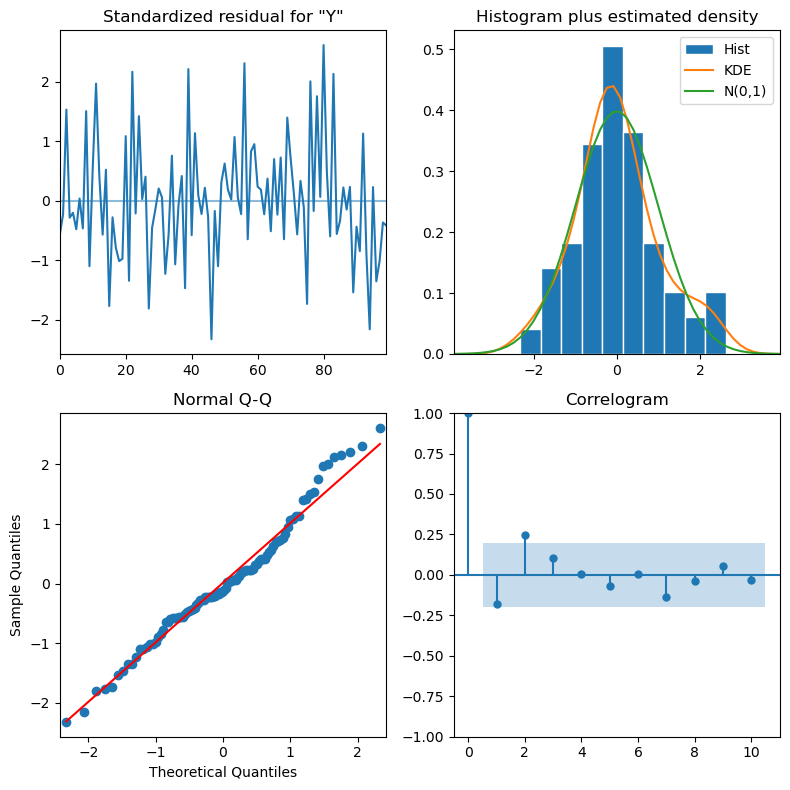

In [172]:
# приведенная форма
mod = sm.tsa.statespace.SARIMAX(data.Y, trend='c', order=(1,0,0), exog = data['x(-1)'])
res = mod.fit(disp = False)
print(res.summary())
print('p-value =', np.round(bgtest(res, nlags = 6)[1], 3))
res.plot_diagnostics(figsize=(8, 8))
plt.tight_layout()


Для модели приведенной формы проверка гипотезы об отсутсвии корреляции в остатках с помощью теста Бройша-Годфри приводит к ее отвержению, тк p-value<0.05. Также коэффициент при $x_{t-1}$  не значим (p-value>0.05 => принятие гипотезы о незначимости коэф). Для модели авторегресии та же гипотеза не отвергается. Следовательно делаем свой выбор в пользу модели авторегрессии.

Полученная модель авторегрессии: \
$y_t=0.8156 + 0.8513y_{t-1} + e_t$

## Задание 8 

Ряды для выполнения этого задания содержатся в файле z_8.csv

Рассмотреть три ряда цен Crude Oil petroleum, Cotton и Coal.

Прологарифмировать данные и рассматривать период с 1995 по 2009 гг.

Если эти ряды относятся к классу I(1) рядов, проверить их на коинтегрированность, и в случае, если они коинтегрированы, определить ранг коинтеграции и построить VECM, соответствующую выбранной ситуации.

In [174]:
df=pd.read_csv('z_8.csv')
df.head(3)


,Date,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Beverage Price Index,Industrial Inputs Price Index,Agricultural Raw Materials Index,Metals Price Index,Fuel Energy Index,...,Sugar Free Market,Sugar U.S. import price,Sunflower oil,Tea,Tin,Uranium,Wheat,Wool coarse,Wool fine,Zinc
0,1980-01-01,NaN,NaN,NaN,NaN,189.310021,81.889650,78.900146,84.049004,NaN,...,17.299999,19.660000,566.926957,225.179901,16973.587904,40.0,175.634750,553.120940,684.277366,773.821533
1,1980-02-01,NaN,NaN,NaN,NaN,190.387928,83.048367,75.715154,88.345232,NaN,...,22.750000,24.689999,573.958609,233.094498,17090.213164,38.0,172.695236,568.154805,722.567093,868.620361
2,1980-03-01,NaN,NaN,NaN,NaN,194.060355,75.228895,69.002475,79.726312,NaN,...,19.630001,21.180000,535.284522,226.833298,17460.590400,35.0,163.509323,552.745109,695.956860,740.752441


In [177]:
data=df[['Date','Crude Oil petroleum','Cotton','Coal']].copy()
data['x']=np.log(data['Crude Oil petroleum'])
data['y']=np.log(data['Cotton'])
data['z']=np.log(data['Coal'])
date_range = (data.Date <= '2009-12-31') & (data.Date >'1995-01-01')
data=data[date_range].reset_index(drop=True).copy()

In [178]:
data

,Date,Crude Oil petroleum,Cotton,Coal,x,y,z
0,1995-02-01,32.723968,99.962502,37.600000,3.488108,4.604795,3.627004
1,1995-03-01,32.548862,110.474998,38.350000,3.482742,4.704789,3.646755
2,1995-04-01,35.191157,113.224998,37.100000,3.560795,4.729377,3.613617
3,1995-05-01,34.549898,115.849998,38.770000,3.542405,4.752296,3.657647
4,1995-06-01,32.504798,104.357498,40.770000,3.481388,4.647822,3.707947
...,...,...,...,...,...,...,...
174,2009-08-01,134.684875,64.255000,77.882143,4.902938,4.162860,4.355197
175,2009-09-01,128.465473,64.072727,73.149351,4.855660,4.160019,4.292503
176,2009-10-01,139.211730,66.820455,75.703734,4.935996,4.202009,4.326827
177,2009-11-01,145.824321,71.776190,82.265306,4.982403,4.273553,4.409949


### 1) Единичные корни (предполагаем отсутствие структурных сдвигов) 

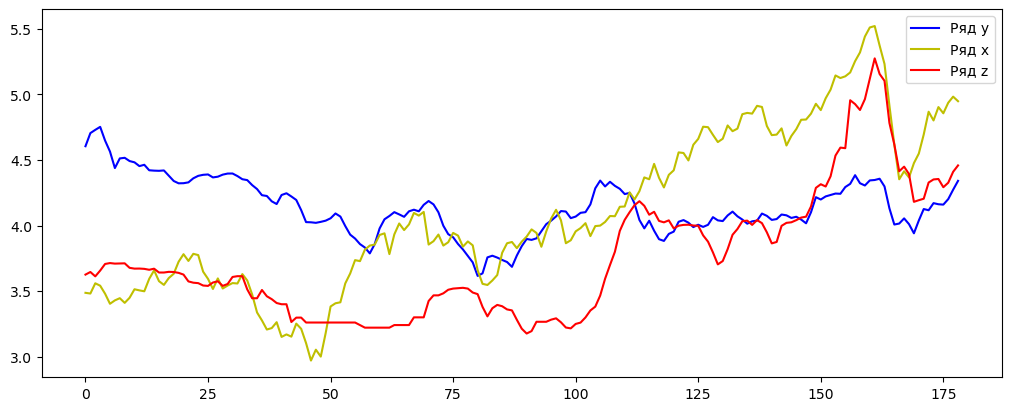

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.plot(data['y'],'b-', label = 'Ряд y')
ax.plot(data['x'],'y-', label = 'Ряд x')
ax.plot(data['z'],'r-', label = 'Ряд z')

ax.legend()

plt.show()

In [ ]:
# Ряд X
#H0: I(1)
print(adf_test(data['x'], 'ct').bic,adf_test(data['x'], 'c').bic,adf_test(data['x'], 'n').bic)
#По bic лучше моедль без const и trend

Results of Dickey-Fuller Test:
Test Statistic                  -3.255109
p-value                          0.073969
#Lags Used                       2.000000
Number of Observations Used    176.000000
Critical Value (1%)             -4.011150
Critical Value (5%)             -3.435735
Critical Value (10%)            -3.141872
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.079997
p-value                          0.722982
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   0.784529
p-value                          0.882301
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -2.578487
Critical Value (5%)             -1.942619
Critical Value (10%)            -1.61

In [ ]:
adf_test(data['x'], 'n')

Results of Dickey-Fuller Test:
Test Statistic                   0.784529
p-value                          0.882301
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -2.578487
Critical Value (5%)             -1.942619
Critical Value (10%)            -1.615401
dtype: float64


In [ ]:
print(adf_test(data['y'], 'ct').bic,adf_test(data['y'], 'c').bic,adf_test(data['y'], 'n').bic)
#по bic лучше с константой

Results of Dickey-Fuller Test:
Test Statistic                  -2.266556
p-value                          0.452530
#Lags Used                       6.000000
Number of Observations Used    172.000000
Critical Value (1%)             -4.012392
Critical Value (5%)             -3.436330
Critical Value (10%)            -3.142220
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.469680
p-value                          0.123027
#Lags Used                       6.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -0.058676
p-value                          0.664420
#Lags Used                       6.000000
Number of Observations Used    172.000000
Critical Value (1%)             -2.578861
Critical Value (5%)             -1.942669
Critical Value (10%)            -1.61

In [ ]:
adf_test(data['y'], 'c').bic

Results of Dickey-Fuller Test:
Test Statistic                  -2.469680
p-value                          0.123027
#Lags Used                       6.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64


-563.438893149088

In [ ]:
print(adf_test(data['z'], 'ct').bic,adf_test(data['z'], 'c').bic,adf_test(data['z'], 'n').bic)
#по bic лучше с константой и трендом

Results of Dickey-Fuller Test:
Test Statistic                  -2.633612
p-value                          0.264666
#Lags Used                      11.000000
Number of Observations Used    167.000000
Critical Value (1%)             -4.014028
Critical Value (5%)             -3.437114
Critical Value (10%)            -3.142678
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -0.883470
p-value                          0.793367
#Lags Used                      12.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   0.519476
p-value                          0.829313
#Lags Used                      12.000000
Number of Observations Used    166.000000
Critical Value (1%)             -2.579340
Critical Value (5%)             -1.942733
Critical Value (10%)            -1.61

In [ ]:
adf_test(data['z'], 'ct').bic

Results of Dickey-Fuller Test:
Test Statistic                  -2.633612
p-value                          0.264666
#Lags Used                      11.000000
Number of Observations Used    167.000000
Critical Value (1%)             -4.014028
Critical Value (5%)             -3.437114
Critical Value (10%)            -3.142678
dtype: float64


-411.6577594508546

Для всех трех рядов гипотеза единичного корня не отвергается ( p_value>0.05) следовательно все три ряда I(1)

### 2) Используя метод Йохансена, оценить ранг коинтеграции системы, выбрав ситуацию, соответствующую наблюдаемой динамике этих рядов. В качестве критерия использовать **AIC** 


In [185]:
# выберем порядок модели VAR(P)->VECM(P-1)
mod = VAR(data[['x', 'y', 'z']])
mod.select_order(maxlags =7).summary()

,AIC,BIC,FPE,HQIC
0,-7.157,-7.102,0.0007791,-7.135
1,-16.64,-16.42*,5.939e-08,-16.55
2,-16.79,-16.41,5.083e-08,-16.64*
3,-16.82*,-16.27,4.971e-08*,-16.59
4,-16.74,-16.03,5.357e-08,-16.45
5,-16.69,-15.81,5.644e-08,-16.34
6,-16.65,-15.61,5.869e-08,-16.23
7,-16.65,-15.44,5.919e-08,-16.16


Лучшая модель по aic модель  VAR(3) -> VECM(2)

In [180]:
# переберём варианты, указывая число запаздываюющих разностей в VECM
joh_test(data[['x', 'y', 'z']], n_lags_diff = 2)

Модель 1  ранг коинтеграции:  no cointegration
Модель 2  ранг коинтеграции:  1
Модель 3  ранг коинтеграции:  1
Модель 4  ранг коинтеграции:  1
Модель 5  ранг коинтеграции:  3


In [181]:
# выбрать лучшую по значению AIC VECM-модель - модель номер 1 - var в разностях, те коинтеграции нет  (минимальный aic) :
vecm_selection(data[['x', 'y', 'z']], n_lags_diff = 2)

Модель VAR в разностях n   ранг коинтеграции: 0 AIC = -16.74 BIC = -16.58 Log L = 737.0
Модель VECM 2   ранг коинтеграции: 1 AIC = -8.386 BIC = -8.1 Log L = 753.94
Модель VECM 3   ранг коинтеграции: 1 AIC = -8.371 BIC = -8.05 Log L = 754.69
Модель VECM 4   ранг коинтеграции: 1 AIC = -8.386 BIC = -8.08 Log L = 754.97
Модель VECM 5   ранг коинтеграции: 3 AIC = -8.342 BIC = -7.75 Log L = 767.07


По aic лучшая модель это модель без коинтеграции а именно var в разностях, те коинтеграции между рядами нет => строим var в разностях

### 3) Оцените модель коррекции ошибок для этой системы 3 рядов (с оцененным рангом и с выбранной ситуацией). Преподаватель сообщил, что один из указанных рядов точно будет экзогенным. По результатам оценивания объясните, какой это ряд и почему (10 очков)

In [182]:
data['dY'] = data['y'].diff(1)
data['dX'] = data['x'].diff(1)
data['dZ'] = data['z'].diff(1)

Коинтеграции между рядами нет, но они при это нестационарные => нужно оценивать var в разностях

In [184]:
mod = VAR(data[['dX', 'dY', 'dZ']].dropna())
res = mod.fit(1)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Jul, 2025
Time:                     23:23:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -16.4998
Nobs:                     177.000    HQIC:                  -16.6278
Log likelihood:           737.835    FPE:                5.50438e-08
AIC:                     -16.7152    Det(Omega_mle):     5.14746e-08
--------------------------------------------------------------------
Results for equation dX
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.006671         0.006436            1.037           0.300
L1.dX         0.206993         0.079289            2.611           0.009
L1.dY         0.223865         0.133778            1.673           0.094
L1.dZ         0.062697

По результам оценивания ряд DX и ряд DY будут экзогенными так как коэффиценты для всех переменных кроме dx и dy у них незначимы


Итоговая модель VAR в разностях: \
$ΔX_t=0.207ΔX_{t-1}$\
$ΔY_t=0.384ΔY_{t-1}$\
$ΔZ_t=0.268ΔY_{t-1}+0.274ΔZ_{t-1}$